In [3]:
import sys
sys.path.append('../coding')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from analysis.information import AdaptationChannel
from analysis.plotting import pmf_plot

publication_directory = '../manuscript'

res_df = pd.read_pickle('../data/transition_rates.pkl')

efficiencies = {}

for ix, sub_df in res_df.groupby(level=[0,1,2]):
    channel = AdaptationChannel(sub_df.loc[ix])
    efficiencies[ix] = channel.obtain_efficiency(method='jimbo')
    print(ix)


efficiencies = pd.Series(efficiencies)

C:\Users\Administrator\iCloudDrive\Documents\skola\doktorat\ms-thesis\program\optimization\__init__.py:7: RuntimeWarning: invalid value encountered in true_divide
  specificity = sr_grid / prior


(0.0, 250, 'CH')
(0.0, 250, 'FS')
(0.0, 250, 'IB')
(0.0, 250, 'RS')
(0.0, 500, 'CH')
(0.0, 500, 'FS')
(0.0, 500, 'IB')
(0.0, 500, 'RS')
(0.0, 750, 'CH')
(0.0, 750, 'FS')
(0.0, 750, 'IB')
(0.0, 750, 'RS')
(0.0, 1000, 'CH')
(0.0, 1000, 'FS')
(0.0, 1000, 'IB')
(0.0, 1000, 'RS')
(0.2, 250, 'CH')
(0.2, 250, 'FS')
(0.2, 250, 'IB')
(0.2, 250, 'RS')
(0.2, 500, 'CH')
(0.2, 500, 'FS')
(0.2, 500, 'IB')
(0.2, 500, 'RS')
(0.2, 750, 'CH')
(0.2, 750, 'FS')
(0.2, 750, 'IB')
(0.2, 750, 'RS')
(0.2, 1000, 'CH')
(0.2, 1000, 'FS')
(0.2, 1000, 'IB')
(0.2, 1000, 'RS')
(0.4, 250, 'CH')
(0.4, 250, 'FS')
(0.4, 250, 'IB')
(0.4, 250, 'RS')
(0.4, 500, 'CH')
(0.4, 500, 'FS')
(0.4, 500, 'IB')
(0.4, 500, 'RS')
(0.4, 750, 'CH')
(0.4, 750, 'FS')
(0.4, 750, 'IB')
(0.4, 750, 'RS')
(0.4, 1000, 'CH')
(0.4, 1000, 'FS')
(0.4, 1000, 'IB')
(0.4, 1000, 'RS')
(0.6, 250, 'CH')
(0.6, 250, 'FS')
(0.6, 250, 'IB')
(0.6, 250, 'RS')
(0.6, 500, 'CH')
(0.6, 500, 'FS')
(0.6, 500, 'IB')
(0.6, 500, 'RS')
(0.6, 750, 'CH')
(0.6, 750, 'FS')
(0

In [3]:
inh_levels = efficiencies.index.get_level_values(0).unique().values

In [2]:
from matsim import ShotNoiseConductance, OUConductance, Neuron, get_mat

In [3]:
RS = get_mat('RS')
IB = get_mat('IB')
FS = get_mat('FS')
CH = get_mat('CH')

neuron = Neuron(
    resting_potential=-80,
    membrane_resistance=50,
    membrane_capacitance=0.1,
    mats=[RS, IB, FS, CH]
)

exc = ShotNoiseConductance(
    rate=2.67,
    g_peak=0.0015,
    reversal=0,
    decay=3)

inh = ShotNoiseConductance(
    rate=3.73,
    g_peak=0.0015,
    reversal=-75,
    decay=10)

neuron.append_conductance(exc)
neuron.append_conductance(inh)

In [4]:
from tqdm import tqdm_notebook as tqdm

def intensity_freq_func(intensity, B):
    exc = 2.67 * intensity
    inh = 3.73 * (1 + B * (intensity - 1))
    return exc, inh

dt = 0.1
time = 50000

neuron.time = 0
RS.reset_spike_times()
IB.reset_spike_times()
FS.reset_spike_times()
CH.reset_spike_times()

results = {}

for B in tqdm([0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    for intensity in tqdm(np.logspace(0, 1.6, 20)):
        V_arr = []

        tot_time = 0

        exc_intensity, inh_intensity = intensity_freq_func(intensity, B=B)

        exc.set_rate(exc_intensity)
        inh.set_rate(inh_intensity)

        while tot_time < time:
            tot_time += dt
            neuron.timestep(dt)
            V_arr.append(neuron.voltage)
        
        results[(B, intensity)] = {'mean': np.mean(V_arr[1000:]), 'std': np.std(V_arr[1000:])}

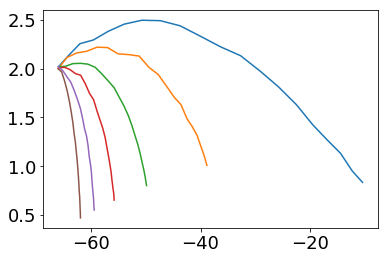

In [5]:
volt_df = pd.DataFrame(results).T

for ix, sub_df in volt_df.groupby(level=0):
    plt.plot(sub_df['mean'], sub_df['std'])

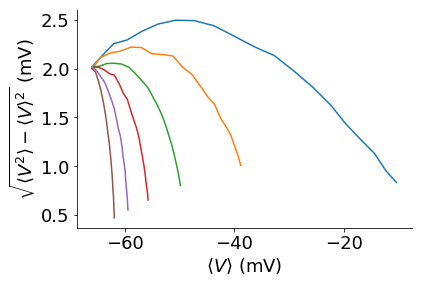

In [6]:
def voltage_plot(ax):
    for ix, sub_df in volt_df.groupby(level=0):
        ax.plot(sub_df['mean'], sub_df['std'])

    for side in ['right','top']:
        ax.spines[side].set_visible(False)
    
    ax.set_xlabel(r'$\langle V\rangle$ (mV)')
    ax.set_ylabel(r'$\sqrt{\langle V^2\rangle - \langle V\rangle^2}$ (mV)')

f, ax = plt.subplots()

voltage_plot(ax)

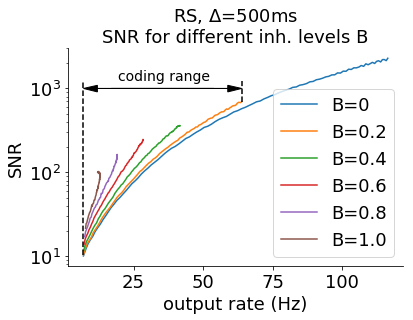

In [4]:
def rates_mu(rates):
    return rates.dot(np.arange(rates.shape[1]))

def rates_std(rates):
    mu = rates_mu(rates)
    
    outs = np.arange(rates.shape[1])
    
    std = np.sqrt(rates.dot(outs * outs) - mu ** 2)
    return std

mus = efficiencies.map(lambda x: x['rates']).map(rates_mu)
stds = efficiencies.map(lambda x: x['rates']).map(rates_std)

def plot_out_snr(ax, nname='RS', coding_range=True):
    for side in ['right','top']:
        ax.spines[side].set_visible(False)

    mus_RS = mus.swaplevel(0,1).loc[500].swaplevel(0,1).loc[nname]
    stds_RS = stds.swaplevel(0,1).loc[500].swaplevel(0,1).loc[nname]
    
    for B in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.plot(mus_RS.loc[B] * 2, (mus_RS.loc[B] / stds_RS.loc[B]) ** 2, label=f'B={B}')
    
    ax.set_yscale('log')
    
    if coding_range == True:
        B = 0.2

        ymin1 = (mus_RS.loc[B][0] / stds_RS.loc[B][0]) ** 2
        ymin2 = (mus_RS.loc[B][-1] / stds_RS.loc[B][-1]) ** 2

        xmin = mus_RS.loc[0.2][0] * 2
        xmax = mus_RS.loc[0.2][-1] * 2

        ylim = ax.get_ylim()

        ymin1_ratio = (np.log10(ymin1) - np.log10(ylim[0])) / (np.log10(ylim[1]) - np.log10(ylim[0]))
        ymin2_ratio = (np.log10(ymin2) - np.log10(ylim[0])) / (np.log10(ylim[1]) - np.log10(ylim[0]))

        ax.axvline(xmin, ymin1_ratio, 0.85, c='black', linestyle='dashed')
        ax.axvline(xmax, ymin2_ratio, 0.85, c='black', linestyle='dashed')

        ax.arrow(xmin + 10, 1e3, xmax - xmin - 10, 0,
                length_includes_head=True,
                width=1,
                head_width=180,
                head_length=5,
                color='black')

        ax.arrow(xmax - 10, 1e3, -(xmax - xmin - 10), 0,
                length_includes_head=True,
                width=1,
                head_width=180,
                head_length=5,
                color='black')

        ax.text(x=19.5, y=1.25e3, s='coding range', fontsize=14)
    
    # plt.xscale('log')
    ax.legend()
    ax.set_xlabel('output rate (Hz)')
    ax.set_ylabel('SNR');
    ax.set_title('RS, $\Delta$=500ms\nSNR for different inh. levels B')


f, ax = plt.subplots()

plot_out_snr(ax)
# plt.savefig(f'{publication_directory}/img/snr.pdf', bbox_inches='tight')

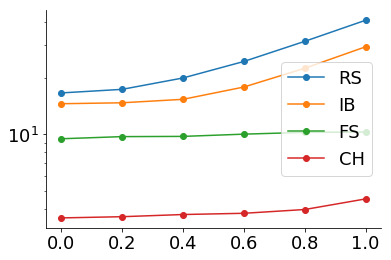

In [5]:
from scipy.interpolate import UnivariateSpline

def evaluate_snr(ix, out_freq):
    x = mus.loc[ix]
    try:
        stop = np.argwhere(np.diff(x) < 0).flatten()[0]
    except IndexError:
        stop = len(x)
    y = (mus.loc[ix] / stds.loc[ix]) ** 2
    
    func = UnivariateSpline(x[:stop] * 1000 / ix[1], y[:stop], k=1, s=0)
    
    return func(out_freq)

def plot_snr_at_val(ax):
    Bs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    for neuron in ['RS','IB','FS','CH']:
        res = []
        for B in Bs:
            res.append(evaluate_snr((B, 500, neuron), 10))
        ax.plot(Bs, res, label=neuron, marker='o')
    
    ax.legend()

    for side in ['right','top']:
        ax.spines[side].set_visible(False)
#     ax.set_yscale('log')

f, ax = plt.subplots()
plot_snr_at_val(ax)
ax.set_yscale('log')

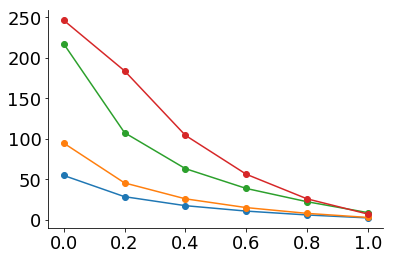

In [6]:
def plot_coding_range(ax):
    Bs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    for neuron in ['RS','IB','FS','CH']:
        res = []
        for B in Bs:
            row = mus.loc[B,500,neuron]
            res.append(row[-1] - row[0])
        ax.plot(Bs, res, label=neuron, marker='o')

    for side in ['right','top']:
        ax.spines[side].set_visible(False)

f, ax = plt.subplots()
plot_coding_range(ax)

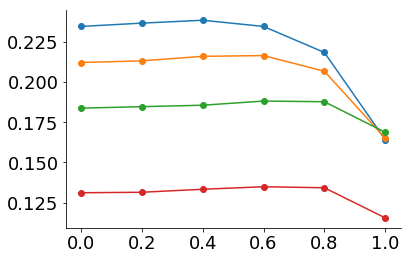

In [7]:
tw = 500

f, ax = plt.subplots()

def plot_eff(ax):
    efficiencies.map(lambda x: x['fun'] / x['expense']).swaplevel(0,1).loc[tw].unstack()[['RS','IB','FS','CH']].\
        plot(marker='o', ax=ax, legend=False)

    for side in ['right','top']:
        ax.spines[side].set_visible(False)

plot_eff(ax)

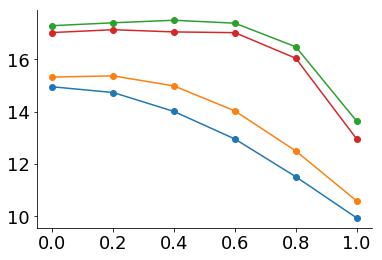

In [8]:
tw = 500

f, ax = plt.subplots()

def plot_expense(ax):
    efficiencies.map(lambda x: x['expense'] * 2).swaplevel(0,1).loc[tw].unstack()[['RS','IB','FS','CH']].\
        plot(marker='o', ax=ax, legend=False)

    for side in ['right','top']:
        ax.spines[side].set_visible(False)
    

plot_expense(ax)

/Users/tomasbarta/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


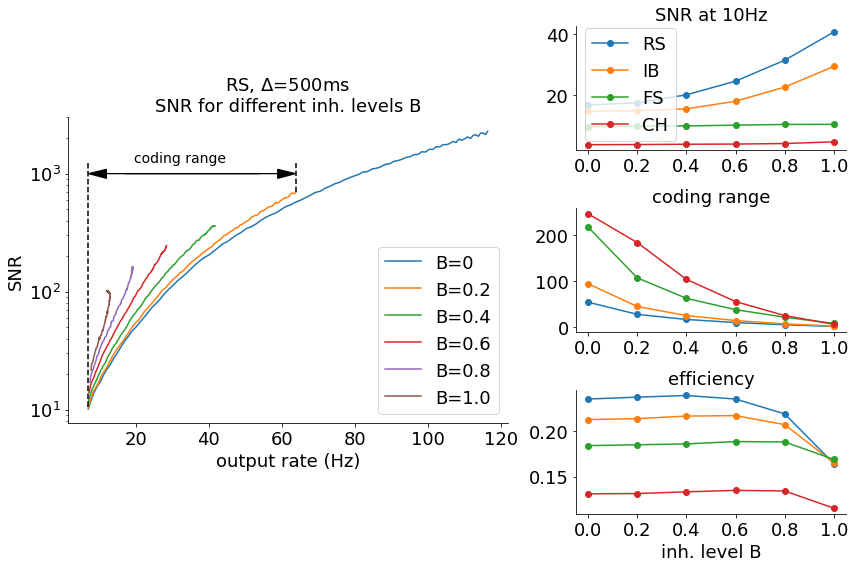

In [14]:
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(12,8))

gs1 = gridspec.GridSpec(6, 5)

# CAPACITY-COST

# ax1 = plt.subplot(gs1[0,1:3])
ax2 = plt.subplot(gs1[1:5,0:3])

ax3 = plt.subplot(gs1[0:2,3:])
ax4 = plt.subplot(gs1[2:4,3:])
ax5 = plt.subplot(gs1[4:6,3:])

# voltage_plot(ax1)
plot_out_snr(ax2)
plot_snr_at_val(ax3)
ax3.set_title('SNR at 10Hz')

plot_coding_range(ax4)
ax4.set_title('coding range')

plot_eff(ax5)
ax5.set_title('efficiency')

for ax in [ax3, ax4, ax5]:
    ax.set_xticks(inh_levels)

ax5.set_xlabel('inh. level B')

plt.savefig(f'{publication_directory}/img/snr_inhib.pdf', bbox_inches='tight')